# **INTERPRETING PDP/ICE PLOTS-PITFALLS**

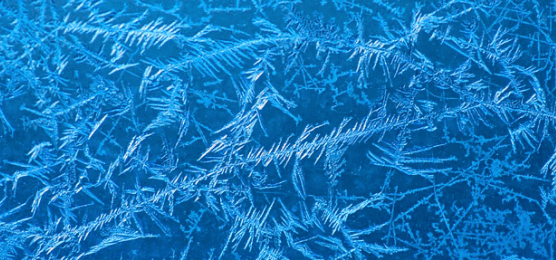

# Table Of Contents
* [Introduction](#intro)
* [Exploring Continious Variables](#continious)
* [Exploring Categorical Variables](#categorical)
* [Fitting Regression Model and Goodness of Fit(no correlated variable)](#fit_1)
* [Partial Dependence Plot(no correlated variable)](#pdp_1)
* [Fitting Regression Model and Goodness of Fit(correlated variable included)](#fit_2)
* [Partial Dependence Plot(correlated variable included)](#pdp_2)
* [Comparasion of the two PDP charts](#comp_1)
* [Fitting Regression Model and Goodness of Fit - Categorical Case(no correlated variable)](#fit_3)
* [Partial Dependence Plot - Categorical Case(no correlated variable)](#pdp_3)
* [Fitting Regression Model and Goodness of Fit - Categorical Case(correlated variable included)](#fit_4)
* [Partial Dependence Plot - Categorical Case(correlated variable included)](#pdp_4)
* [Comparasion of the two PDP charts - Categorical Case](#comp_2)
* [Conclusion](#conclusion)

<a id="intro"></a>
# Introduction

Interpretabilty in Machine Learning Models has become a crucial area of research and application. In this notebook we consider Partial Dependence Plots and Individual Conditional Expectation(ICE) plots. These are post hoc techniques used to observe how the model takes a decision by keeping all exogenous variables fixed, except one(also two in case of PDPs) which is regarded as the feature of interest. This variable is allowed to take all the possible values and we observe its marginal effect on the model’s decision making.

We observe how Feature Dependence(bewteeen Exogenous Variables) can lead to misleading interpretaions of PDPs.

[Medium Article](https://towardsdatascience.com/pitfalls-to-avoid-while-interpreting-machine-learning-pdp-ice-case-c63eeb596590)

#### Importing Necessery Libraries

In [ ]:
import numpy as np
import pandas as pd
import calendar
from scipy.stats import kendalltau
import seaborn as sns
from sklearn import preprocessing
from yellowbrick.features import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.target import FeatureCorrelation
from yellowbrick.regressor import ResidualsPlot
from pdpbox import pdp, info_plots
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

In [ ]:
df = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
df.head()

#### Extracting Date time features from data

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime']) 
df['year'] = df['datetime'].dt.year #Extract Year feature
df['month'] = df['datetime'].dt.month #Extract Month feature
df['hour'] = df['datetime'].dt.hour #Extract Hour feature
df.head()

#### TARGET VARIABLE
The **'count'** feature which is a sum of 'casual' and 'registered'

<a id="continious"></a>
# Exploring continious variables

In [ ]:
continious_variables = df[['temp', 'atemp', 'humidity', 'windspeed','count']]
continious_variables.columns = ['temp', 'atemp', 'humidity', 'windspeed','number_of_rentals']
sns.pairplot(continious_variables,x_vars=['temp', 'atemp', 'humidity', 'windspeed'],y_vars=['number_of_rentals'],
            height=5, aspect=.8, kind="reg")
plt.show()             

**Inference** :
* 'temp' has a positive linear relationship with 'count'
* 'atemp' has a positive linear relationship with 'count'
* 'humidity' has a negative linear relationship with 'count'
* 'windspeed' has a positive linear relationship with 'count'

#### Pearson Correlation

In [ ]:
corr = continious_variables.corr() #Check Pearson Correlation
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, fmt="f",cmap="Blues")

#### Mutual Information(Only Continiuos Variables)

In [ ]:
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=continious_variables.columns)

visualizer.fit(continious_variables.loc[:,continious_variables.columns!='number_of_rentals'], \
               continious_variables.loc[:,continious_variables.columns=='number_of_rentals'], \
               random_state=0)
visualizer.show()

Inference:
**'temp**' and **'atemp'** are heavily correlated, which is very intuitive, also have very high mutual information w.r.t the target variable 'count'. Both of these variables are definite picks for our regression.Also, **'humidity'** can be considered as a feature for our Regression.

#### Target Plot

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=continious_variables, feature='temp', feature_name='temp', target='number_of_rentals', show_percentile=True
)

In [ ]:
summary_df

Inference:
With the feature 'temp' values broken into percentiles, we observe the count of bookings made  and the mean 'count' in each percentile. It seems with rising temperature the mean count of booking goes up consistently. However, the number of bookings made is highest in 77.78-88.89 percentile brackets.

<a id="categorical"></a>
# Exploring categorical variables

In [ ]:
categorical_data = df[['season', 'holiday', 'workingday', 'weather','month','year','hour','count']]
#Extract the category codes
categorical_data = categorical_data.astype('category')
categorical_data['season'] = categorical_data['season'].cat.codes
categorical_data['holiday'] = categorical_data['holiday'].cat.codes
categorical_data['workingday'] = categorical_data['workingday'].cat.codes
categorical_data['weather'] = categorical_data['weather'].cat.codes

#### Mutual Information(Only categorical Variables)

In [ ]:
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=categorical_data.columns)

visualizer.fit(categorical_data.loc[:,categorical_data.columns!='count'], \
               categorical_data.loc[:,categorical_data.columns=='count'], \
               random_state=0)
visualizer.show()

Inference:
The 'hour' variable seems to play a very significant role in determining the number of rental in a day as per our Mutual Information plot. 

#### Catergorical to 'temp' Plot

In [ ]:
sns.lmplot(x="temp", y="count", col="season", data=df,
           aspect=.5);

In [ ]:
sns.lmplot(x="temp", y="count", col="holiday", data=df,
           aspect=.5);

#### ANOVA Analysis

In [ ]:
#Quantify 'temp' -> 'holiday' relationship
model = smf.ols(formula='temp ~ C(holiday)', data=df)
res = model.fit()
print('ANOVA - temp~holiday')
summary = res.summary()
print(summary.tables[0])

#Quantify 'atemp' -> 'holiday' relationship
model = smf.ols(formula='atemp ~ C(holiday)', data=df)
res = model.fit()
print('ANOVA - temp~holiday')
summary = res.summary()
print(summary.tables[0])

In [ ]:
#Quantify 'temp' -> 'month' relationship
model = smf.ols(formula='temp ~ C(month)', data=df)
res = model.fit()
print('ANOVA - temp~month')
summary = res.summary()
print(summary.tables[0])

#Quantify 'atemp' -> 'month' relationship
model = smf.ols(formula='atemp ~ C(month)', data=df)
res = model.fit()
print('ANOVA - atemp~month')
summary = res.summary()
print(summary.tables[0])

In [ ]:
#Quantify 'temp' -> 'season' relationship
model = smf.ols(formula='temp ~ C(season)', data=df)
res = model.fit()
print('ANOVA - temp~season')
summary = res.summary()
print(summary.tables[0])

#Quantify 'atemp' -> 'season' relationship
model = smf.ols(formula='atemp ~ C(season)', data=df)
res = model.fit()
print('ANOVA - atemp~season')
summary = res.summary()
print(summary.tables[0])

#### Inference
Based on the P-values of the F-Statistic, we can conclude that group means of both 'temp' and 'atemp' are different accross the categories of 'season' and 'month'.
This is intuitive, because temperature means(avergage) across different months/season will certainly vary.

<a id="fit_1"></a>
# Fitting Regression Model and Goodness of Fit(no correlated variable)
In this case, we don't consider any highly correlated variable in our feature list.

In [ ]:
X,y = df[['year','hour','temp','humidity','windspeed','holiday','workingday']],df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=200)
visualizer = ResidualsPlot(model, qqplot=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

Inference:
A random,uniform distribution of residuals with a (approximately)zero mean, implies a good fit.Not to mention about the good R-squared value(for both train and test).

<a id="pdp_1"></a>
# Partial Dependence Plot(no correlated variable)

In [ ]:
pdp_temp = pdp.pdp_isolate(
    model=model, dataset=X_train, model_features=X_train.columns, feature='temp'
)
fig, axes = pdp.pdp_plot(pdp_temp, 'temp',center=False, cluster=True,n_cluster_centers=2,\
                         plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True)

In [ ]:
print('Get the PDP values',pdp_temp.pdp)

#### Inference: 
We create a PDP plot to capture marginal effects of 'temp' and we capture ICE plots using two clustered verison of all the ICE plots for ease of visulaization(the two ICE plots are the two thin blue lines).What the PDP reveals is that with increase in the 'temp' values the sell of the rentals go up, until a point. After the temperature goes up beyond 30, we see diminishing sales. This explanation seems pretty intuitive. The sales are higher when the temperature is niether too hot nor too cold(pleasant).

<a id="fit_2"></a>
# Fitting Regression Model and Goodness of Fit(correlated variable included)
We consider both 'temp' and 'atemp' in this case, both of which are continiuos and highly correlated.

In [ ]:
X,y = df[['year','hour','temp','atemp','humidity','windspeed','holiday','workingday']],df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=200)
visualizer = ResidualsPlot(model, qqplot=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<a id="pdp_2"></a>
# Partial Dependence Plot(correlated variable included)

In [ ]:
pdp_temp = pdp.pdp_isolate(
    model=model, dataset=X_train, model_features=X_train.columns, feature='temp'
)
fig, axes = pdp.pdp_plot(pdp_temp, 'temp',center=False, cluster=True,n_cluster_centers=2,\
                         plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True)

In [ ]:
print('Get the PDP values',pdp_temp.pdp)

<a id="comp_1"></a>
# Comparasion of the two PDP charts
Although on an an overall level the marginal effects of 'temp' can be explained as influencing sales the best when the values are moderate. But in the second case(with correlated varaibles), we see spurious results. The PDP is very much a flat line. The first case has an average value of 77.6 number of rentals booked for the first percentile of 'temp', while in the second case, the average value is 145. The PDP is lot flatter in the second case.**Why?**

#### Debugging the second PDP plot(one with correlated variables)

In [ ]:
#Get all the extrapolated 'temp' values used for the PDP
X_train['month'] = df[df.index.isin(X_train.index)]['month']
X_train['month'] = X_train['month'].apply(lambda x: calendar.month_abbr[x])
#Extract all the extrapolated data points
X_train['extrapolated_temp'] = [pdp_temp.feature_grids.tolist()]*len(X_train)
X_train = X_train.explode('extrapolated_temp')
X_train.head()

#### **Pitfall**:
Because PDP is based on perturbations of data, the extrapolated data points generated are actually infeasible and spurious in case of correlated variables case. Consider the first row in the above table,the 'atemp' variable has a value of 32.575 in the month of July(which is reasonable) but the corresponding extraploted 'temp' has value of 0.82(in the month of July in Washington D.C). This is laughable. Because of this the marginal effects get cancelled and we get a very flat PDP line. This is a serious pitfall. **The way to avoid it?** Well simple. Take feature dependency seriously and remove the correlated variable(in this case Pearson Correlation).

<a id="fit_3"></a>
# Fitting Regression Model and Goodness of Fit - Categorical Case(no correlated variable)

In [ ]:
X,y = df[['year','hour','season','humidity','windspeed','holiday','workingday']],df['count']
X = pd.get_dummies(X,columns=['season']) # one hot enocode 'season'
#Encode each season
X = X.rename(columns = {'season_1':'spring','season_2':'summer',
                       'season_3':'fall','season_4':'winter'})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.head()

In [ ]:
model = RandomForestRegressor(n_estimators=200)
visualizer = ResidualsPlot(model, qqplot=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<a id="pdp_3"></a>
# Partial Dependence Plot - Categorical Case(no correlated variable)

In [ ]:
pdp_season = pdp.pdp_isolate(
    model=model, dataset=X_train, model_features=X_train.columns, 
    feature=['spring', 'summer', 'fall', 'winter']
)
fig, axes = pdp.pdp_plot(pdp_season,'season', center=False, cluster=True,n_cluster_centers=2,\
                         plot_lines=True, x_quantile=True, show_percentile=True)

In [ ]:
print('Categorical PDP values',pdp_season.pdp)

#### Inference: 
We create a PDP plot to capture marginal effects of 'season' and we capture ICE plots using two clustered verison of all the ICE plots for ease of visulaization(the two ICE plots are the two thin blue lines).What the PDP reveals is that with season being either Spring or Winter the number of rental sales on an average is 118.8 and 201.476 respectively. The sales are maximum during Summers and Falls(217 and 230.4 on an average respectively). 

<a id="fit_4"></a>
# Fitting Regression Model and Goodness of Fit - Categorical Case(correlated variable included)

In [ ]:
X,y = df[['year','hour','temp','season','humidity','windspeed','holiday','workingday']],df['count']
X = pd.get_dummies(X,columns=['season']) # one hot enocode 'season'
X = X.rename(columns = {'season_1':'spring','season_2':'summer',
                       'season_3':'fall','season_4':'winter'})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.head()

In [ ]:
model = RandomForestRegressor(n_estimators=200)
visualizer = ResidualsPlot(model, qqplot=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<a id="pdp_4"></a>
# Partial Dependence Plot - Categorical Case(correlated variable included)

In [ ]:
pdp_season = pdp.pdp_isolate(
    model=model, dataset=X_train, model_features=X_train.columns, 
    feature=['spring', 'summer', 'fall', 'winter']
)
fig, axes = pdp.pdp_plot(pdp_season,'season', center=False, cluster=True,n_cluster_centers=2,\
                         plot_lines=True, x_quantile=True, show_percentile=True)

In [ ]:
print('Categorical PDP values',pdp_season.pdp)

<a id="comp_2"></a>
# Comparasion of the two PDP charts - Categorical Case
Although on an an overall level the marginal effects of 'season' can be explained as influencing sales the best when the seasons are Summer or Fall. But in the second case(with correlated varaibles), we see spurious results. The PDP is very much a flat line. **Why?**

#### Debugging the second PDP plot(one with correlated variables)

In [ ]:
#Get all the extrapolated 'season' categories used for the PDP
X_train['month'] = df[df.index.isin(X_train.index)]['month']
X_train['month'] = X_train['month'].apply(lambda x: calendar.month_abbr[x])
#Extract all the extrapolated data points
X_train['extrapolated_season'] = [pdp_season.feature_grids.tolist()]*len(X_train)
X_train = X_train.explode('extrapolated_season')
X_train.head()

#### **Pitfall**:
We observe similar results as in case of the correlated case(this time with categorical to continious dependecy). The month of July can never be the season of Spring/Winter.
We should consider Categorical to Continiuos Dependency seriously too. This means only Pearson Correlation is not suffiecient and techniques like ANOVA should be taken into account. Based on ANOVA, if the mean of groups of a continious variable are significantly different for atleast one category, then we should remove this dependecy from our analysis.

<a id="conclusion"></a>
# **Conclusion**

Along with linear depencies we have to further check for Non Linear depencies too. Although dependent variables do not create adverse effects while fitting the model but they can ruin our interpretations when we use technques like PDP/ICE.